# Produce synthetic discrete gaussian data

In [1]:
import sys
sys.path.append("../src/")

import numpy as np

import matplotlib.pyplot as plt

from mask import simulate_mask
from plotting import plot_profile, plot_hmap
from splitting import train_val_split

from dg_data_generator.dg_generator import (
    simulate_float_from_named_basis,
    simulate_integer_from_float
)

%matplotlib inline

In [2]:
SEED = 42

PATH_TO_DATA = "/Users/sela/Desktop/recsys/data/gd_data/100p_verify_gdl"
PATH_TO_DROPOUT = '/Users/sela/phd/data/real/Pdropout_2Krandom.npy'

# Synthesize complete profiles

In [3]:
M = simulate_float_from_named_basis(
    basis_name='simple_peaks', 
    N=100, T=321, K=5, 
    domain=[1, 4], 
    seed=SEED
)

integer_parameters = {
    'output_domain': np.arange(1, 5),
    'kernel_parameter': 2.5,
}

D = simulate_integer_from_float(
    M, 
    integer_parameters,
    return_float=False,
    seed=SEED
)

# Sparsening

In [4]:
parameters_simulate_mask = {
    'mask_screening_proba': np.array([0.05, 0.15, 0.40, 0.60, 0.20]),
    'memory_length': 10,
    'mask_level': 1000 #0.6
}

M = simulate_mask(
    D,
    mask_parameters=parameters_simulate_mask,
    path_dropout=PATH_TO_DROPOUT,
    seed=SEED
)

In [5]:
X = D * M

# Training and validation sets

In [6]:
prediction_window = 4

O_train, O_val = train_val_split(X, prediction_window, method='last_observed', seed=SEED)

X_val = X * O_val
X_train = X * O_train

# Inspect

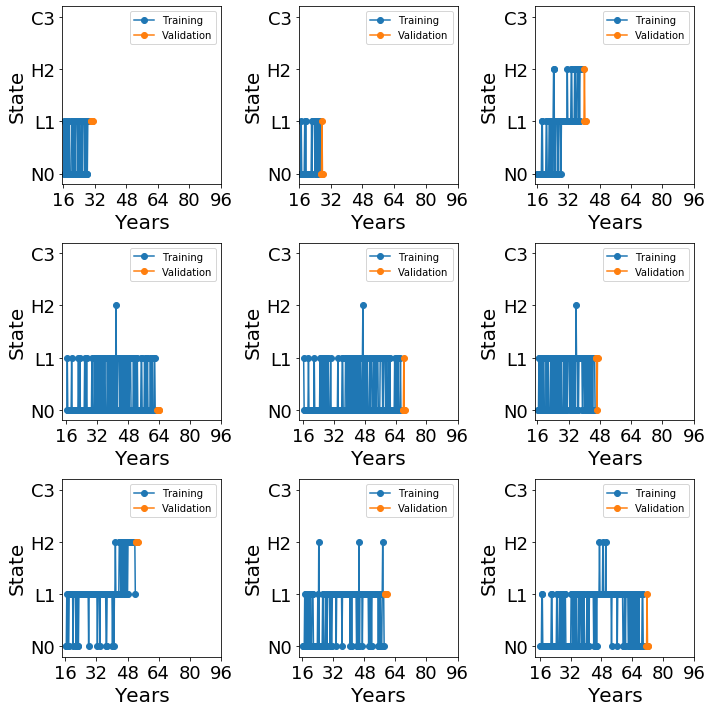

In [7]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for num, axis in enumerate(axes.ravel()):
    
    # Add plot to figure.
    plot_profile(X_val[num], axis, show=False, label='Training')
    plot_profile(X_train[num], axis, show=False, label='Validation')
    
    axis.legend()

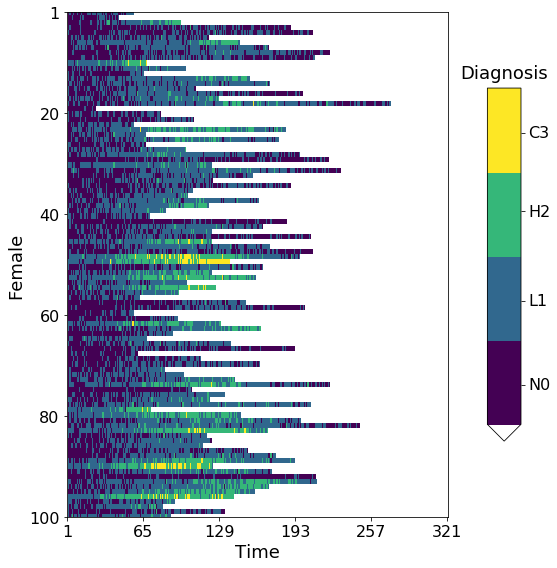

States: [1. 2. 3. 4.]
Counts: [5045 7082 1419  138]
Number of all-zero profiles: 0


In [8]:
fig = plt.figure(figsize=(8, 8))
plot_hmap(fig, X_val)

vals, cnts = np.unique(X_val[X_val != 0], return_counts=True)
print('States:', vals)
print('Counts:', cnts)

# Sanity check.
print('Number of all-zero profiles:', len(np.squeeze(np.where(np.sum(X_val, axis=1) == 0))))

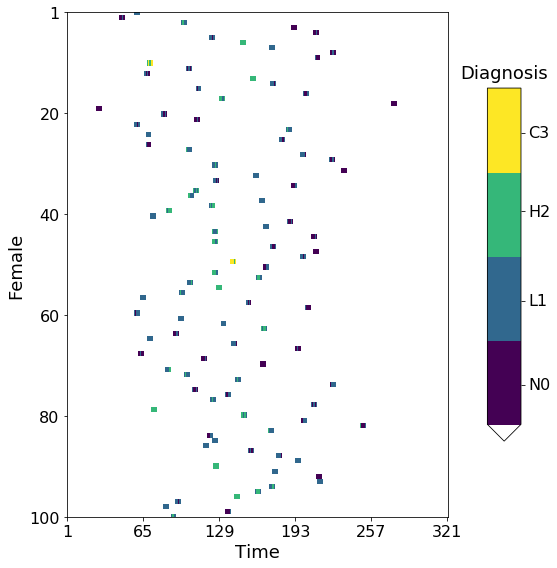

States: [1. 2. 3. 4.]
Counts: [142 269  83   6]
Number of all-zero profiles: 0


In [9]:
fig = plt.figure(figsize=(8, 8))
plot_hmap(fig, X_train)

vals, cnts = np.unique(X_train[X_train != 0], return_counts=True)
print('States:', vals)
print('Counts:', cnts)

# Sanity check.
print('Number of all-zero profiles:', len(np.squeeze(np.where(np.sum(X_train, axis=1) == 0))))

# Save data to disk

In [10]:
np.save(f'{PATH_TO_DATA}/X.npy', X)
np.save(f'{PATH_TO_DATA}/O_val.npy', O_val)
np.save(f'{PATH_TO_DATA}/O_train.npy', O_train)